##1. import & Data load

In [1]:
from torch import cuda

cuda.is_available()

True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install catboost
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.9 MB/s eta 0:00:00


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm import tqdm
import bisect
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score, KFold

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings(action='ignore')

In [28]:
train = pd.read_csv('/content/drive/MyDrive/프로젝트/HD현대 AI Challenge/data/train.csv').drop(columns=['SAMPLE_ID','ID'])
test = pd.read_csv('/content/drive/MyDrive/프로젝트/HD현대 AI Challenge/data/test.csv').drop(columns=['SAMPLE_ID','ID'])

train, test SAMPLE_ID, ID 삭제

##2. EDA & Preprocessing

In [29]:
# 데이터 탐색
display(train.head())
display(train.info())
display(train.describe())
# 결측치 확인
display(train.isnull().sum())

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
0,SG,GIW5,Container,30.881018,2018-12-17 21:29,30.0,24,24300,10.0,10.0,...,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,5,0.002615,3.450000
1,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,30.0,13,35900,10.0,10.0,...,180.0,SPNO34,Marshall Islands,NaN,NaN,NaN,NaN,12,0.000217,0.000000
2,CN,EUC8,Container,0.000000,2015-02-03 22:00,50.0,12,146000,30.0,20.0,...,370.0,FNPK22,Malta,NaN,NaN,NaN,NaN,6,0.001614,0.000000
3,JP,ZAG4,Container,0.000000,2020-01-17 4:02,20.0,18,6910,10.0,10.0,...,120.0,PBZV77,Bahamas,-3.18,-1.61,6.7,2.629350,13,0.000356,0.000000
4,SG,GIW5,Container,27.037650,2020-01-26 7:51,50.0,10,116000,20.0,10.0,...,300.0,GUCE76,Liberia,-0.33,-3.28,25.6,2.495953,15,0.002615,253.554444


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              391939 non-null  object 
 1   ARI_PO              391939 non-null  object 
 2   SHIP_TYPE_CATEGORY  391939 non-null  object 
 3   DIST                391939 non-null  float64
 4   ATA                 391939 non-null  object 
 5   BREADTH             391938 non-null  float64
 6   BUILT               391939 non-null  int64  
 7   DEADWEIGHT          391939 non-null  int64  
 8   DEPTH               391938 non-null  float64
 9   DRAUGHT             391938 non-null  float64
 10  GT                  391939 non-null  int64  
 11  LENGTH              391938 non-null  float64
 12  SHIPMANAGER         391939 non-null  object 
 13  FLAG                391939 non-null  object 
 14  U_WIND              228251 non-null  float64
 15  V_WIND              228251 non-nul

None

,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
count,391939.000000,391938.00000,391939.000000,391939.000000,391938.000000,391938.000000,391939.000000,391938.000000,228251.000000,228251.000000,227309.000000,228251.000000,391939.000000,391939.000000,391939.000000
mean,19.328187,30.55001,14.747989,63577.506780,16.476177,11.088106,41348.968666,205.121320,-0.294910,-0.263849,18.862968,2.706992,11.841580,0.000876,61.940835
std,30.930059,10.95707,7.043988,63515.531024,6.045930,4.599298,39304.543664,75.873891,3.366585,3.736949,9.729976,1.388026,6.644114,0.000838,170.809558
min,0.000000,10.00000,0.000000,100.000000,0.000000,0.000000,150.000000,20.000000,-25.330000,-21.450000,-32.200000,0.000000,0.000000,0.000005,0.000000
25%,0.000000,20.00000,10.000000,14300.000000,10.000000,10.000000,10000.000000,150.000000,-2.150000,-2.280000,12.200000,1.805246,7.000000,0.000142,0.000000
50%,6.929678,30.00000,13.000000,47400.000000,20.000000,10.000000,30700.000000,190.000000,-0.130000,0.000000,21.600000,2.618063,12.000000,0.000552,7.944444
75%,25.692827,40.00000,18.000000,81500.000000,20.000000,10.000000,52100.000000,260.000000,1.540000,2.000000,26.600000,3.556236,17.000000,0.001614,49.176111
max,199.980651,60.00000,80.000000,404000.000000,30.000000,20.000000,237000.000000,400.000000,17.910000,29.690000,47.600000,11.179660,23.000000,0.002615,2159.130556


ARI_CO                     0
ARI_PO                     0
SHIP_TYPE_CATEGORY         0
DIST                       0
ATA                        0
BREADTH                    1
BUILT                      0
DEADWEIGHT                 0
DEPTH                      1
DRAUGHT                    1
GT                         0
LENGTH                     1
SHIPMANAGER                0
FLAG                       0
U_WIND                163688
V_WIND                163688
AIR_TEMPERATURE       164630
BN                    163688
ATA_LT                     0
PORT_SIZE                  0
CI_HOUR                    0
dtype: int64

1. 범주형 변수: ARI_CO, ARI_PO, SHIP_TYPE_CATEGORY ,SHIPMANAGER ,FLAG
2. 수치형 변수: 나머지
3. 풍향 u,v벡터, 기온, 보퍼트 풍력 계급 변수에 결측치 존재

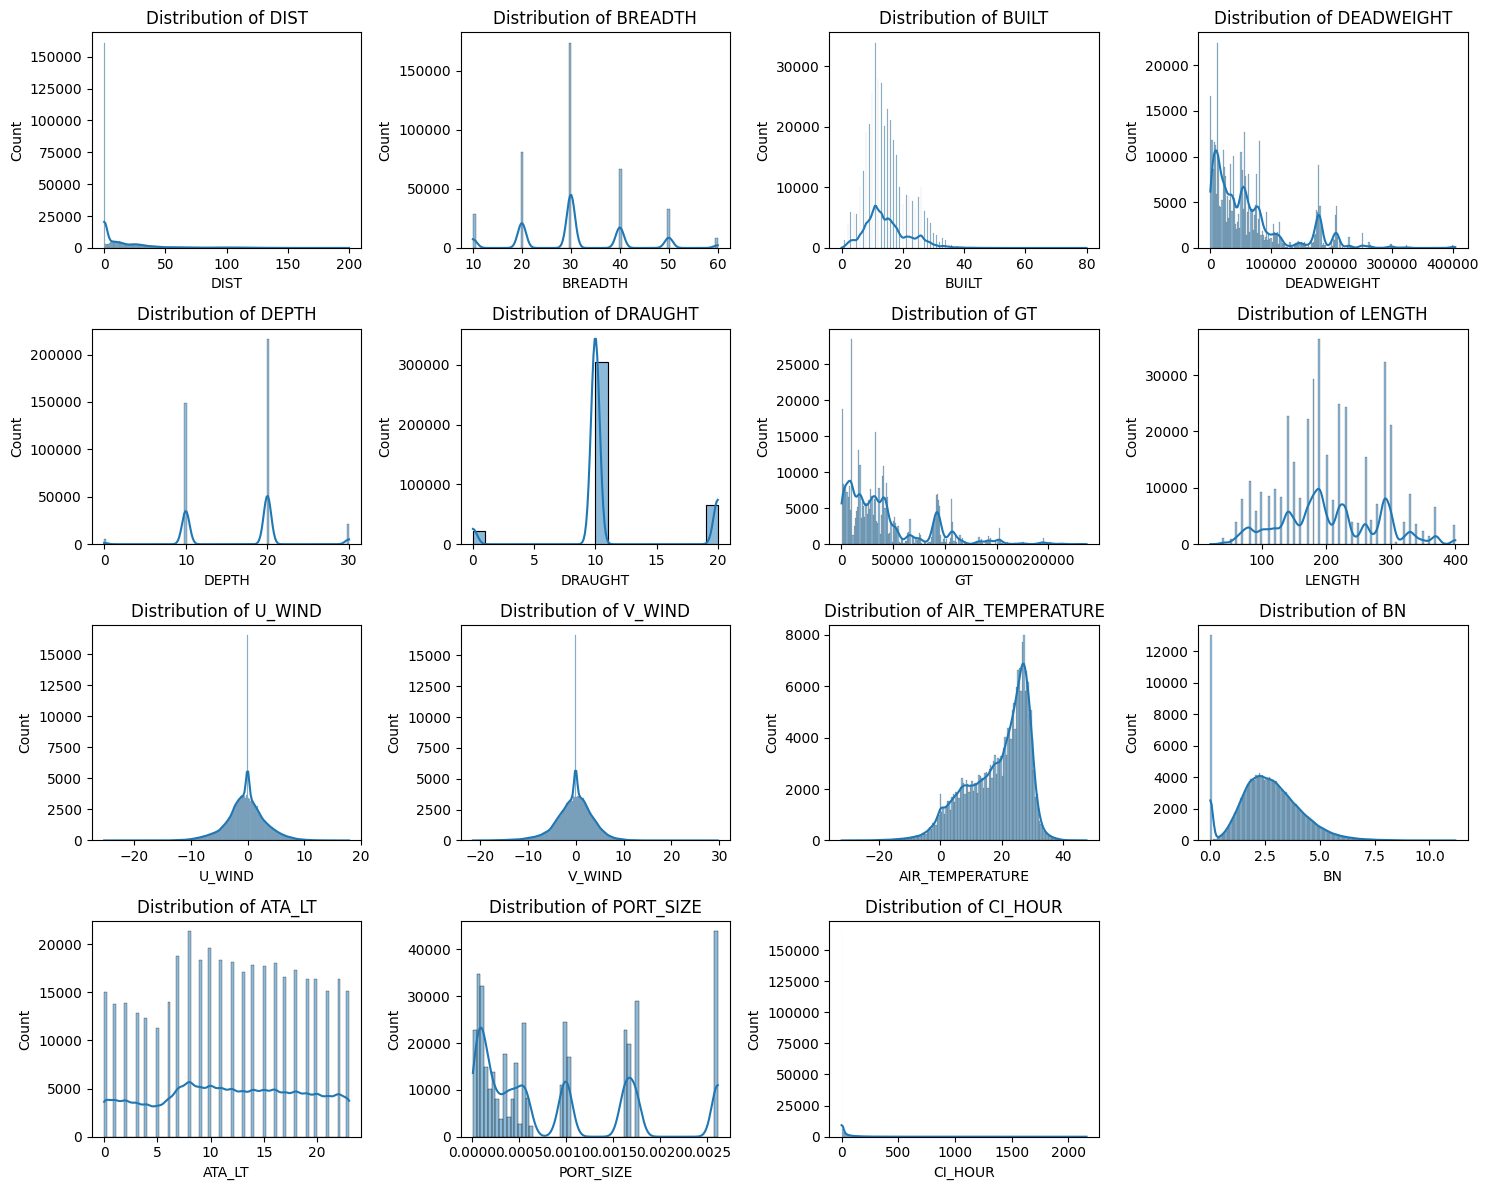

In [ ]:
num_cols=['DIST', 'BREADTH', 'BUILT','DEADWEIGHT', 'DEPTH','DRAUGHT', 'GT', 'LENGTH', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN','ATA_LT', 'PORT_SIZE','CI_HOUR']

# 그래프의 크기 및 행, 열 설정
num_cols_count = len(num_cols)
num_cols_per_row = 4  # 각 행당 그래프 수를 조절
num_rows = int(math.ceil(num_cols_count / num_cols_per_row))

plt.figure(figsize=(15, 3 * num_rows))

for i, feature in enumerate(num_cols, 1):
    plt.subplot(num_rows, num_cols_per_row, i)
    sns.histplot(train[feature], kde=True)
    plt.title(f'Distribution of {feature}')

# 그래프 출력
plt.tight_layout()
plt.show()

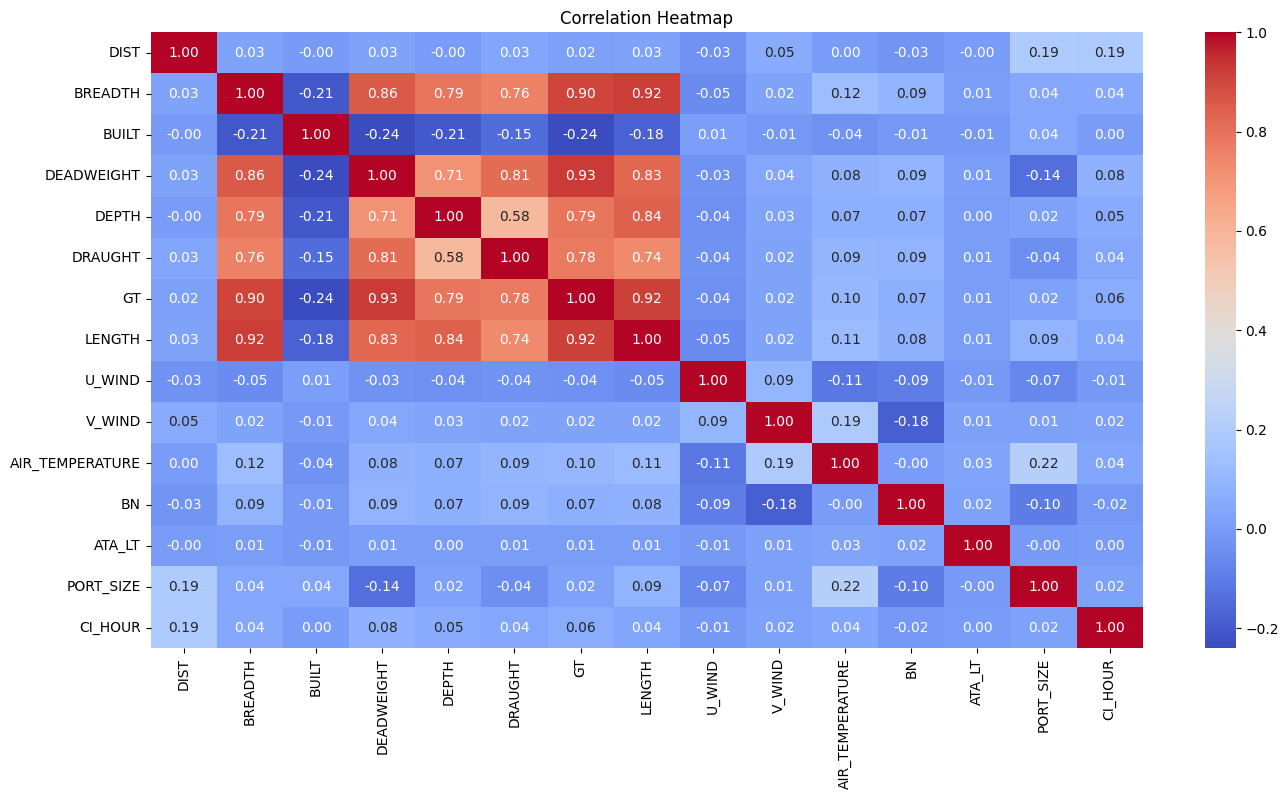

In [ ]:
# 시각화를 통한 데이터 탐색
plt.figure(figsize=(16, 8))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

1. DIST 변수가 제일 상관관계 높았지만 유의미한 수준이 아님
2. 선박의 크기및 용적량 변수들 끼리의 상관계수 높게 측정

* breadth, deadweight, depth, draught, gt, length - [폭, 재화중량톤수, 깊이, 흘수높이, 용적톤수, 길이]

In [30]:
# DIST가 0이면 CI_HOUR도 0이어야함 - 개념적으로
DIST_0 = train[train['DIST'] == 0]
CI_HOUR_NOT_0_idx = DIST_0.index[DIST_0['CI_HOUR'] != 0].tolist()
print(CI_HOUR_NOT_0_idx)
train.loc[CI_HOUR_NOT_0_idx, ['CI_HOUR']] = 0
train

[2521, 6439, 24059, 26501, 36741, 39476, 59076, 66864, 69524, 73609, 77864, 111963, 114363, 130517, 146884, 196830, 212002, 215246, 237240, 237396, 270856, 297812, 306130, 314316, 350939, 357643, 378544, 389245]


,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
0,SG,GIW5,Container,30.881018,2018-12-17 21:29,30.0,24,24300,10.0,10.0,...,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,5,0.002615,3.450000
1,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,30.0,13,35900,10.0,10.0,...,180.0,SPNO34,Marshall Islands,NaN,NaN,NaN,NaN,12,0.000217,0.000000
2,CN,EUC8,Container,0.000000,2015-02-03 22:00,50.0,12,146000,30.0,20.0,...,370.0,FNPK22,Malta,NaN,NaN,NaN,NaN,6,0.001614,0.000000
3,JP,ZAG4,Container,0.000000,2020-01-17 4:02,20.0,18,6910,10.0,10.0,...,120.0,PBZV77,Bahamas,-3.18,-1.61,6.7,2.629350,13,0.000356,0.000000
4,SG,GIW5,Container,27.037650,2020-01-26 7:51,50.0,10,116000,20.0,10.0,...,300.0,GUCE76,Liberia,-0.33,-3.28,25.6,2.495953,15,0.002615,253.554444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391934,JP,QYY1,Container,0.000000,2017-06-06 5:02,20.0,27,6820,10.0,10.0,...,110.0,KEJZ24,"China, People's Republic Of",NaN,NaN,NaN,NaN,14,0.000552,0.000000
391935,SG,GIW5,Bulk,5.884603,2019-10-16 0:36,10.0,12,3160,10.0,10.0,...,80.0,JLTM64,Vietnam,-0.66,0.97,27.3,1.253491,8,0.002615,144.061389
391936,US,QGN3,Bulk,70.660241,2021-03-23 22:35,30.0,8,60300,20.0,10.0,...,200.0,YERJ68,Singapore,-3.44,7.99,21.1,4.766257,18,0.000155,41.482222
391937,TW,JWI3,Container,9.448179,2015-01-08 7:15,30.0,29,23800,10.0,10.0,...,170.0,HCZK58,Comoros,NaN,NaN,NaN,NaN,15,0.000990,7.485278


In [31]:
# BUILT, ATA_LT 컬럼 제거
train.drop(columns=['BUILT', 'ATA_LT'], inplace=True)
test.drop(columns=['BUILT', 'ATA_LT'], inplace=True)

train.head(5)

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,BREADTH,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,PORT_SIZE,CI_HOUR
0,SG,GIW5,Container,30.881018,2018-12-17 21:29,30.0,24300,10.0,10.0,16700,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,0.002615,3.450000
1,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,30.0,35900,10.0,10.0,23500,180.0,SPNO34,Marshall Islands,NaN,NaN,NaN,NaN,0.000217,0.000000
2,CN,EUC8,Container,0.000000,2015-02-03 22:00,50.0,146000,30.0,20.0,140000,370.0,FNPK22,Malta,NaN,NaN,NaN,NaN,0.001614,0.000000
3,JP,ZAG4,Container,0.000000,2020-01-17 4:02,20.0,6910,10.0,10.0,5400,120.0,PBZV77,Bahamas,-3.18,-1.61,6.7,2.629350,0.000356,0.000000
4,SG,GIW5,Container,27.037650,2020-01-26 7:51,50.0,116000,20.0,10.0,96600,300.0,GUCE76,Liberia,-0.33,-3.28,25.6,2.495953,0.002615,253.554444


1. 유의미한 선형적 관계를 볼 수는 없다.
2. BUILT, ATA_LT 컬럼 제거(종속변수와의 선형관계 0)

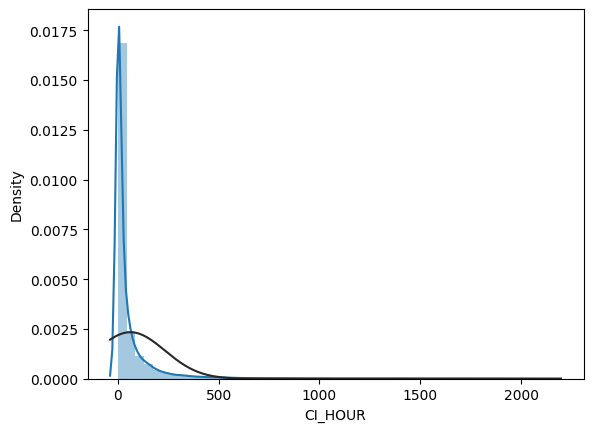

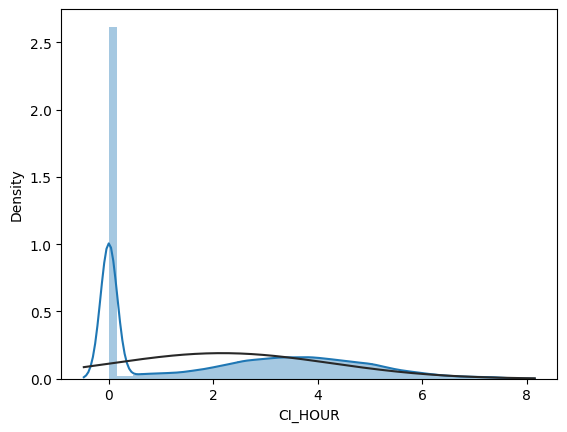

<Figure size 640x480 with 0 Axes>

In [32]:
# 종속변수 Log 변환
sns.distplot(train['CI_HOUR'], fit=norm);
fig = plt.figure()

train.CI_HOUR = np.log1p(train.CI_HOUR)

sns.distplot(train['CI_HOUR'], fit=norm);
fig = plt.figure()

In [33]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

#도착 국가와 항구 합치기
train['ARI_COPO'] = train['ARI_CO'] + '_' + train['ARI_PO']
test['ARI_COPO'] = test['ARI_CO'] + '_' + test['ARI_PO']

# ARI_CO, ARI_PO 컬럼 제거
train.drop(columns=['ARI_CO', 'ARI_PO'], inplace=True)
test.drop(columns=['ARI_CO', 'ARI_PO'], inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_COPO', 'SHIP_TYPE_CATEGORY', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

Encoding features: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


In [34]:
# 수치형 데이터 로그화
def logTransform(data) :
    scaled_cols = data.columns
    scaled_data = data.apply(lambda x: np.log1p(x))
    return scaled_data

left_skewed_cols = ['DEADWEIGHT', 'GT', 'DIST', 'BN']
train[left_skewed_cols] = logTransform(train[left_skewed_cols])
test[left_skewed_cols] = logTransform(test[left_skewed_cols])

# 나머지 수치형 데이터를 MinMaxScaler
num_features=['BREADTH', 'DEPTH', 'DRAUGHT', 'LENGTH', 'U_WIND', 'V_WIND', 'PORT_SIZE']

scaler = MinMaxScaler()
train[num_features] = scaler.fit_transform(train[num_features])
test[num_features] = scaler.transform(test[num_features])

In [35]:
train.head(5)

,SHIP_TYPE_CATEGORY,DIST,BREADTH,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,...,BN,PORT_SIZE,CI_HOUR,year,month,day,hour,minute,weekday,ARI_COPO
0,2,3.462011,0.4,10.098273,0.333333,0.5,9.723224,0.421053,686,89,...,1.310221,1.000000,1.492904,2018,12,17,21,29,0,90
1,0,0.000000,0.4,10.488520,0.333333,0.5,10.064798,0.421053,4720,74,...,1.310221,0.081242,0.000000,2014,9,23,6,59,1,52
2,2,0.000000,0.8,11.891369,1.000000,1.0,11.849405,0.921053,1370,73,...,1.310221,0.616515,0.000000,2015,2,3,22,0,1,23
3,2,0.000000,0.2,8.840870,0.333333,0.5,8.594339,0.263158,3809,5,...,1.289053,0.134672,0.000000,2020,1,17,4,2,4,66
4,2,3.333548,0.8,11.661354,0.666667,0.5,11.478344,0.736842,1687,67,...,1.251606,1.000000,5.539515,2020,1,26,7,51,6,90


1. 범주형 및 datetime 컬럼 처리
2. 수치데이터 로그화 및 MinMaxScaler
3. 종속변수 log 변환

### LGBM feature selection

Model Tune for lgbm.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 391939, number of used features: 22
[LightGBM] [Info] Start training from score 2.163121


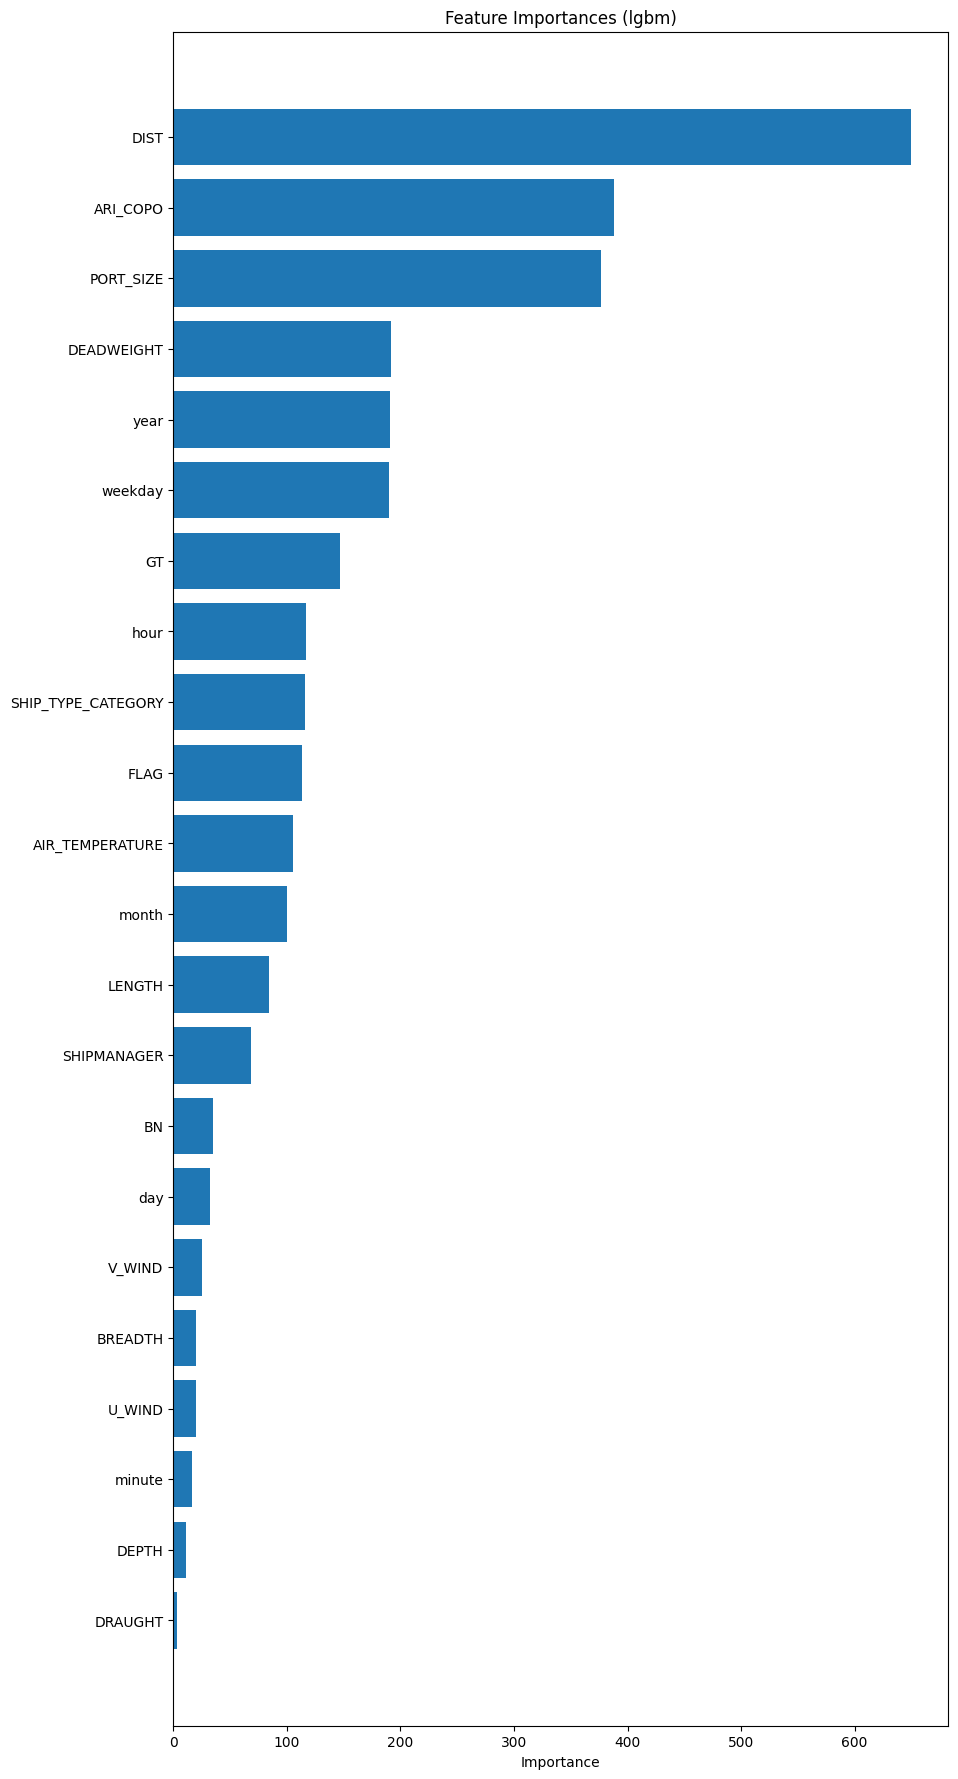

In [36]:
def train_and_evaluate(model, model_name, train_x, train_y):
    print(f'Model Tune for {model_name}.')
    model.fit(train_x, train_y)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(train_x.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(train_x.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(train_x.shape[1]), train_x.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

train_x = train.drop(columns=['CI_HOUR'])
train_y = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'lgbm', train_x, train_y)

In [37]:
lgbm_feature_importances

array([116, 650,  20, 192,  11,   3, 147,  84,  68, 113,  20,  25, 105,
        35, 377, 191, 100,  32, 117,  16, 190, 388], dtype=int32)

In [38]:
train_x = train.drop(columns=['CI_HOUR'])
train_y = train['CI_HOUR']

threshold = 116 # Your Threshold
low_importance_features = train_x.columns[lgbm_feature_importances < threshold]

train_x = train_x.drop(columns=low_importance_features)
test = test.drop(columns=low_importance_features)

In [39]:
low_importance_features

Index(['BREADTH', 'DEPTH', 'DRAUGHT', 'LENGTH', 'SHIPMANAGER', 'FLAG',
       'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN', 'month', 'day', 'minute'],
      dtype='object')

In [40]:
train_x

,SHIP_TYPE_CATEGORY,DIST,DEADWEIGHT,GT,PORT_SIZE,year,hour,weekday,ARI_COPO
0,2,3.462011,10.098273,9.723224,1.000000,2018,21,0,90
1,0,0.000000,10.488520,10.064798,0.081242,2014,6,1,52
2,2,0.000000,11.891369,11.849405,0.616515,2015,22,1,23
3,2,0.000000,8.840870,8.594339,0.134672,2020,4,4,66
4,2,3.333548,11.661354,11.478344,1.000000,2020,7,6,90
...,...,...,...,...,...,...,...,...,...
391934,2,0.000000,8.827761,8.480737,0.209594,2017,5,1,61
391935,0,1.929287,8.058644,7.378384,1.000000,2019,0,2,90
391936,0,4.271936,11.007104,10.457401,0.057661,2021,22,1,97
391937,2,2.346428,10.077483,9.735128,0.377319,2015,7,3,93


In [ ]:
#이후 사용을 위해 저장
train_x.to_csv("/content/drive/MyDrive/프로젝트/HD현대 AI Challenge/data/train_x.csv")
test.to_csv("/content/drive/MyDrive/프로젝트/HD현대 AI Challenge/data/test_x.csv")
train_y.to_csv("/content/drive/MyDrive/프로젝트/HD현대 AI Challenge/data/train_y.csv")

- LGBM 모델 특성 중요도로 특성 삭제
- 전처리된 데이터 저장

##3. 모델 학습 및 검증

### 0. GPU 확인 및 데이터 로드


In [5]:
!nvidia-smi

Sun Oct 29 16:09:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import tensorflow as tf
device_name=tf.test.gpu_device_name()
if device_name!='/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
import tensorflow as tf

# GPU 상태 확인
tf.config.experimental.get_memory_info('GPU:0')


{'current': 0, 'peak': 0}

In [8]:
train_x = pd.read_csv("/content/drive/MyDrive/프로젝트/HD현대 AI Challenge/data/train_x.csv", index_col=0, header=0)
test = pd.read_csv("/content/drive/MyDrive/프로젝트/HD현대 AI Challenge/data/test_x.csv", index_col=0, header=0)
train_y = pd.read_csv("/content/drive/MyDrive/프로젝트/HD현대 AI Challenge/data/train_y.csv", index_col=0, header=0)

print(train_x.shape)
print(test.shape)
print(train_y.shape)

(391939, 9)
(220491, 9)
(391939, 1)


### 1. XGBoost

In [51]:
# Objective function for Optuna optimization
def objective_xgb(trial: Trial):

    X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.1, random_state=42)

    xgb_params = {
       'tree_method': 'gpu_hist',  # GPU 사용
      #  'objective': 'reg:squarederror',
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators':  trial.suggest_categorical('n_estimators', [10000]),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'n_jobs': -1
    }

    # Create the XGBoost model with the suggested hyperparameters
    model = xgb.XGBRegressor(**xgb_params)

    # Fit the model on the training data
    # model.fit(X_train, y_train)
    model.fit(X_train,y_train,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)

    # Make predictions on the validation set
    y_pred = model.predict(X_val)

    # Calculate the MAE for validation
    mae = mean_absolute_error(np.expm1(y_val), np.expm1(y_pred))

    return mae

In [ ]:
# Create a study object and specify the optimization direction (minimize MAE)
sampler = TPESampler(seed=42)  # Use TPE sampler for Bayesian optimization
study = optuna.create_study(direction='minimize', sampler=sampler)

# Optimize the objective function
study.optimize(objective_xgb, n_trials=30)  # You can adjust the number of trials

# Get the best hyperparameters
best_xgb_params = study.best_params

# Print the best hyperparameters
print("Best XGBoost Hyperparameters:")
print(best_xgb_params)

In [41]:
# MAE:42.877
# 'predictor': 'gpu_predictor'는 예측할 때 사용
best_xgb_params={'lambda': 0.18987591670899917, 'alpha': 1.2590393649905778, 'colsample_bytree': 0.9, 'subsample': 0.8,
 'learning_rate': 0.014, 'n_estimators': 4000, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 3,'tree_method': 'gpu_hist','predictor': 'gpu_predictor','n_jobs':-1, 'objective': 'reg:squarederror'}

In [42]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.1, random_state=42)

model = xgb.XGBRegressor(**best_xgb_params)

model.fit(X_train,y_train,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)

y_pred = model.predict(X_val)

mae = mean_absolute_error(np.expm1(y_val), np.expm1(y_pred))

print(mae)

42.877089618744314


In [43]:
# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

xgb_model = xgb.XGBRegressor(**best_xgb_params)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(train_x), total=5, desc="Processing folds"):
    X_t, X_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
    y_t, y_val = train_y[train_idx], train_y[val_idx]

    # 두 모델 모두 학습
    xgb_model.fit(X_t, y_t, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = xgb_model.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(np.expm1(y_val), np.expm1(val_pred)))

    # test 데이터셋에 대한 예측 수행 후 저장
    xgb_pred = xgb_model.predict(test)
    xgb_pred = np.where(xgb_pred < 0, 0, xgb_pred)

    ensemble_predictions.append(np.expm1(xgb_pred))

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions_xgb = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds: 100%|██████████| 10/10 [06:47<00:00, 40.72s/it]

Validation : MAE scores for each fold: [42.91738047465859, 43.19379973181403, 43.228889410456034, 45.781539021033154, 43.695560203694406, 45.067782631630024, 42.36266112408062, 45.31458078018462, 43.866763410592256, 43.38271136983139]
Validation : MAE: 43.88116681579751


K-Fold XGBOOST 제출 47점

### 2. CatBoost

In [ ]:
# Optuna objective함수 - CatBoost
def objective_catboost(trial: Trial):

    X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.1, random_state=42)

    catboost_params = {
        'task_type': 'GPU',
        'bootstrap_type':'Poisson',
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
        #'rsm': trial.suggest_uniform('rsm', 0.3, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.006, 0.018),
        'n_estimators':  trial.suggest_int("n_estimators", 1000, 5000,step=100),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
    }

    model =CatBoostRegressor(**catboost_params)

    model.fit(X_train,y_train,eval_set=[(X_val,y_val)],early_stopping_rounds=200,verbose=False)

    y_pred = model.predict(X_val)

    mae = mean_absolute_error(np.expm1(y_val), np.expm1(y_pred))

    return mae

In [ ]:
# Create a study object and specify the optimization direction (minimize MAE)
sampler = TPESampler(seed=42)  # Use TPE sampler for Bayesian optimization
study = optuna.create_study(direction='minimize', sampler=sampler)

# Optimize the objective function
study.optimize(objective_catboost, n_trials=30)  # You can adjust the number of trials

# Get the best hyperparameters
best_catboost_params = study.best_params

# Print the best hyperparameters
print("Best CatBoost Hyperparameters:")
print(best_catboost_params)

[I 2023-10-26 16:04:13,654] A new study created in memory with name: no-name-33306e54-4ac1-4fd1-a564-4a5c39a45119
[I 2023-10-26 16:05:08,682] Trial 0 finished with value: 48.685582678791306 and parameters: {'iterations': 11865, 'od_wait': 2212, 'learning_rate': 0.7346740023932911, 'reg_lambda': 59.86585243311882, 'subsample': 0.15601864044243652, 'random_strength': 16.239780813448107, 'depth': 1, 'min_data_in_leaf': 26, 'leaf_estimation_iterations': 10, 'bagging_temperature': 6.79657809075816}. Best is trial 0 with value: 48.685582678791306.
[I 2023-10-26 16:05:21,926] Trial 1 finished with value: 45.48968072086596 and parameters: {'iterations': 4432, 'od_wait': 2246, 'learning_rate': 0.8341182143924175, 'reg_lambda': 21.233918944436507, 'subsample': 0.18182496720710062, 'random_strength': 17.33618039413735, 'depth': 5, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.14618962793704965}. Best is trial 1 with value: 45.48968072086596.
[I 2023-10-26 16:07

Best CatBoost Hyperparameters:
{'iterations': 13407, 'od_wait': 932, 'learning_rate': 0.01541507250118919, 'reg_lambda': 73.7303816977707, 'subsample': 0.9977675046799871, 'random_strength': 47.0887667571786, 'depth': 10, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.6570245561699908}


In [ ]:
best_catboost_params={'iterations': 13407, 'od_wait': 932, 'learning_rate': 0.01541507250118919, 'reg_lambda': 73.7303816977707, 'subsample': 0.9977675046799871, 'random_strength': 47.0887667571786, 'depth': 10, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.6570245561699908,'task_type': 'GPU', 'bootstrap_type': 'Poisson'}
best_catboost_params

{'iterations': 13407,
 'od_wait': 932,
 'learning_rate': 0.01541507250118919,
 'reg_lambda': 73.7303816977707,
 'subsample': 0.9977675046799871,
 'random_strength': 47.0887667571786,
 'depth': 10,
 'min_data_in_leaf': 5,
 'leaf_estimation_iterations': 14,
 'bagging_temperature': 0.6570245561699908,
 'task_type': 'GPU',
 'bootstrap_type': 'Poisson'}

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
model =CatBoostRegressor(**best_catboost_params)

model.fit(X_train,y_train,eval_set=[(X_val,y_val)],early_stopping_rounds=200,verbose=False)

y_pred = model.predict(X_val)

mae = mean_absolute_error(np.expm1(y_val), np.expm1(y_pred))
print(mae)

44.170413007743456


In [ ]:
# catboost_model = CatBoostRegressor(**best_catboost_params)

# score = mae_cv(catboost_model)
# catboost_score = score.mean()
# print("CatBoostRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

### 3. LGBM

In [44]:
# Optuna objective함수 - LGBM
def objective_lgbm(trial: Trial):

    X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.1, random_state=42)

    lgbm_params = {
        'objective': 'mae',
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'n_estimators': trial.suggest_categorical('n_estimators', [5000]),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('cat_smooth', 1, 100),
        'n_jobs': -1
    }

    model =lgb.LGBMRegressor(**lgbm_params)

    model.fit(X_train,y_train,eval_set=[(X_val,y_val)],callbacks=[lgb.early_stopping(100,verbose=False)])

    y_pred = model.predict(X_val)

    mae = mean_absolute_error(np.expm1(y_val), np.expm1(y_pred))

    return mae

In [ ]:
# Create a study object and specify the optimization direction (minimize MAE)
sampler = TPESampler(seed=42)  # Use TPE sampler for Bayesian optimization
study = optuna.create_study(direction='minimize', sampler=sampler)

# Optimize the objective function
study.optimize(objective_lgbm, n_trials=30)  # You can adjust the number of trials

# Get the best hyperparameters
best_lgbm_params = study.best_params

# Print the best hyperparameters
print("Best LGBM Hyperparameters:")
print(best_lgbm_params)

In [45]:
# MAE: 42.2366297352669
best_lgbm_params={'random_state': 2020, 'n_estimators': 5000, 'reg_alpha': 0.27663802735692455, 'reg_lambda': 0.005886270633260326,
 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 931, 'min_child_samples': 15,
 'cat_smooth': 27, 'objective': 'mae', 'n_jobs': -1}

In [ ]:
best_lgbm_params={'random_state': 2020, 'n_estimators': 1304, 'reg_alpha': 2.707394216256663, 'reg_lambda': 0.038023491291765396,
                  'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 17, 'num_leaves': 682, 'min_child_samples': 29, 'cat_smooth': 62, 'objective': 'mae','n_jobs': -1}

In [46]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.1, random_state=42)
model =lgb.LGBMRegressor(**best_lgbm_params)

model.fit(X_train,y_train,eval_set=[(X_val,y_val)],callbacks=[lgb.early_stopping(100,verbose=False)])

y_pred = model.predict(X_val)

mae = mean_absolute_error(np.expm1(y_val), np.expm1(y_pred))

print(mae)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1016
[LightGBM] [Info] Number of data points in the train set: 352745, number of used features: 9
[LightGBM] [Info] Start training from score 2.189603


KeyboardInterrupt: ignored

In [ ]:
# 10-Fold 설정
kf = KFold(n_splits=10, shuffle=True, random_state=42)

lgbm_model = lgb.LGBMRegressor(**best_lgbm_params)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(train_x), total=10, desc="Processing folds"):
    X_t, X_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
    y_t, y_val = train_y[train_idx], train_y[val_idx]

    # 두 모델 모두 학습
    lgbm_model.fit(X_train,y_train,eval_set=[(X_val,y_val)],callbacks=[lgb.early_stopping(100,verbose=False)])

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm_model.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(np.expm1(y_val), np.expm1(val_pred)))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm_model.predict(test)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(np.expm1(lgbm_pred))

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions_lgbm = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

###4. 앙상블

In [ ]:
# 'tree_method': 'gpu_hist' 없음
# best_xgb_params={'lambda': 11.301844432706362, 'alpha': 0.510704000002835, 'colsample_bytree': 0.9126912634499058, 'subsample': 0.9494229824513081, 'learning_rate': 0.02384727905665833, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 0, 'gamma': 0.0040832097981139785, 'scale_pos_weight': 2.0645359355109343,
#  'max_delta_step': 8.596331811005982, 'n_estimators': 20000}
best_xgb_params={'lambda': 0.24601423885722784, 'alpha': 6.033394157525111, 'colsample_bytree': 0.9087176135445203, 'subsample': 0.7447439543868675, 'learning_rate': 0.013719242731121354, 'n_estimators': 3583,
 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 4, 'gamma': 0.002494016147386861, 'scale_pos_weight': 2.7409796165086453, 'max_delta_step': 17.02571429271371}
# 'task_type': 'GPU' , 'bootstrap_type': 'Poisson'없음
best_catboost_params={'iterations': 13407, 'od_wait': 932, 'learning_rate': 0.01541507250118919, 'reg_lambda': 73.7303816977707, 'subsample': 0.9977675046799871, 'random_strength': 47.0887667571786, 'depth': 10, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.6570245561699908}
best_lgbm_params={'random_state': 2020, 'reg_alpha': 0.001003318444795568, 'reg_lambda': 1.7508811487115383, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 100,
 'num_leaves': 872, 'min_child_samples': 24, 'min_data_per_groups': 39, 'n_estimators': 1514, 'objective': 'regression', 'metric': 'mae'}

xgb_model = xgb.XGBRegressor(**best_xgb_params)
catboost_model = model =CatBoostRegressor(**best_catboost_params)
lgbm_model = lgb.LGBMRegressor(**best_lgbm_params)

print(xgb_model)
print(catboost_model)
print(lgbm_model)

XGBRegressor(alpha=6.033394157525111, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9087176135445203, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.002494016147386861,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.24601423885722784,
             learning_rate=0.013719242731121354, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=17.02571429271371, max_depth=13, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3583, n_jobs=None, ...)
LGBMRegressor(learning_rate=0.02, max_depth=100, metric='mae',
              min_child_samples=24, min_data_per_groups=39, n_estimators=1514,
              num_leaves=872, obje

In [ ]:
from mlxtend.regressor import StackingCVRegressor
# Stacking
stack  = StackingCVRegressor(
    regressors=[xgb_model, catboost_model, lgbm_model],
    meta_regressor=xgb_model,
    use_features_in_secondary=True,
    random_state=2020,  # 선택적: 시드 설정
    n_jobs=-1  # 선택적: 병렬 작업을 위한 CPU 코어 수 설정
)

# Stacking 모델을 학습
stack_model=stack .fit(np.array(train_x), train_y)

final_predictions = stack_model.predict(np.array(test))

KeyboardInterrupt: ignored

In [ ]:
final_predictions=np.expm1(final_predictions)

##4. 결과 제출

In [53]:
# 제출용 sample 파일불러오기
submission = pd.read_csv('/content/drive/MyDrive/프로젝트/HD현대 AI Challenge/data/sample_submission.csv')
submission.shape

(220491, 2)

In [54]:
# submission15 -> 로그변환 + Minmaxscaler + 종속변수 로그화 + XGBOOST
submission["CI_HOUR"]=final_predictions_xgb
submission.head()

,SAMPLE_ID,CI_HOUR
0,TEST_000000,18.003187
1,TEST_000001,31.559025
2,TEST_000002,58.397041
3,TEST_000003,67.604843
4,TEST_000004,0.150300


In [ ]:
# submission13 -> 이상치 제거(종속변수 제외) + 표준화 + 종속변수 로그화 + XGBOOST,LGBM,CatBoost stacking
submission["CI_HOUR"]=final_predictions
submission.head()

In [ ]:
# submission12 -> 이상치 제거(종속변수 제외) + 표준화 + 종속변수 로그화 + LGBM
submission["CI_HOUR"]=final_predictions
submission.head()

,SAMPLE_ID,CI_HOUR
0,TEST_000000,10.799928
1,TEST_000001,11.744837
2,TEST_000002,30.073310
3,TEST_000003,66.107192
4,TEST_000004,0.000004


In [55]:
submission.to_csv("/content/drive/MyDrive/프로젝트/HD현대 AI Challenge/data/submission15.csv",index = False)